In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA



In [2]:
df_trends= pd.read_csv('/Users/althaaframadhan/Documents/Skripsi/Penelitian/Transformation/trends_ctn.csv')


In [3]:
print(df_trends.head())
print(df_trends.info())

   Platform  Hashtag  Content_Type  Region    Views   Likes  Shares  Comments  \
0         0        1             5       2  3239663  288436   94297      5399   
1         0        3             1       5  3759036   49515   94487     19525   
2         0        6             3       1  3697216  209784   41633     19831   
3         1        5             1       1  2878436  149765    9840     42118   
4         1        4             0       3  1213710  468518    1746     24547   

   Engagement_Level  
0                 0  
1                 2  
2                 2  
3                 0  
4                 0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Platform          200 non-null    int64
 1   Hashtag           200 non-null    int64
 2   Content_Type      200 non-null    int64
 3   Region            200 non-null    int64
 4   Vi

In [4]:

feature_cols = df_trends.select_dtypes(include=['int64', 'float64']).columns
feature_cols = [c for c in feature_cols if c in df_trends.columns]
X = df_trends[feature_cols].values

In [5]:
# Cell 3: fungsi evaluate k range
def evaluate_k_range(X, k_min=2, k_max=10, use_mini_batch=False, random_state=42):
    ks = list(range(k_min, k_max+1))
    inertias = []
    silhouettes = []
    ch_scores = []
    for k in ks:
        if use_mini_batch:
            model = MiniBatchKMeans(n_clusters=k, random_state=random_state, n_init=10, batch_size=256)
        else:
            model = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = model.fit_predict(X)
        inertias.append(model.inertia_)
        try:
            silhouettes.append(silhouette_score(X, labels))
        except Exception:
            silhouettes.append(np.nan)
        try:
            ch_scores.append(calinski_harabasz_score(X, labels))
        except Exception:
            ch_scores.append(np.nan)
    return ks, np.array(inertias), np.array(silhouettes), np.array(ch_scores)


In [6]:
# Cell 4: jalankan evaluasi k (sesuaikan range jika perlu)
ks, inertias, silhouettes, ch_scores = evaluate_k_range(X, k_min=2, k_max=10, use_mini_batch=False)
print("K Values", ks)
print("Inertias", inertias)
print("Silhouettes", silhouettes)
print("Calinski-Harabasz Scores", ch_scores)

K Values [2, 3, 4, 5, 6, 7, 8, 9, 10]
Inertias [1.13512575e+14 4.08633756e+13 2.81683709e+13 1.98375915e+13
 1.33821249e+13 1.08919989e+13 9.62760142e+12 8.54744868e+12
 7.58231291e+12]
Silhouettes [0.62542308 0.63326572 0.56442054 0.54409612 0.512815   0.48810341
 0.4600421  0.42580231 0.40891061]
Calinski-Harabasz Scores [ 618.0179362  1029.16598594 1019.72122784 1100.89609005 1317.59174503
 1349.41626699 1305.36710982 1282.85351644 1281.41932064]


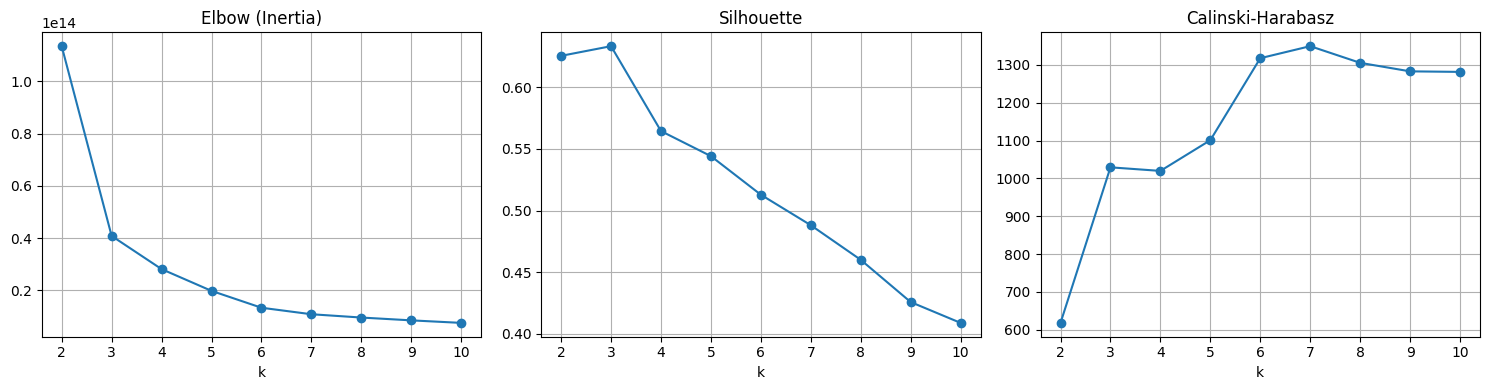

In [7]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(ks, inertias, marker='o')
plt.title("Elbow (Inertia)")
plt.xlabel("k")
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(ks, silhouettes, marker='o')
plt.title("Silhouette")
plt.xlabel("k")
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(ks, ch_scores, marker='o')
plt.title("Calinski-Harabasz")
plt.xlabel("k")
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Tentukan k terbaik berdasarkan fungsi evaluate
if np.all(np.isnan(silhouettes)):
    k_best = int(ks[np.argmin(inertias)])  
else:
    k_best = int(ks[np.nanargmax(silhouettes)])
k_best


3

In [9]:
# Cell 7: fungsi fit KMeans dan analisa 

def fit_kmeans_and_analyze(X, df_original=df_trends, n_clusters=3, random_state=42, feature_cols=None, use_mini_batch=False):
    if use_mini_batch:
        model = MiniBatchKMeans(n_clusters=n_clusters, init='random', random_state=random_state, n_init=10, batch_size=256)
    else:
        model = KMeans(n_clusters=n_clusters,init='random', random_state=random_state, n_init=10)

    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels) if len(set(labels))>1 else np.nan
    ch = calinski_harabasz_score(X, labels) if len(set(labels))>1 else np.nan
    inertia = model.inertia_
    
    if df_original is not None:
        result_df = df_original.copy()
        result_df["cluster"] = labels
    else:
        result_df = pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])
        result_df["cluster"] = labels

    summary = result_df.groupby("cluster").agg(count=("cluster","size"))
    numeric_cols = [c for c in result_df.select_dtypes(include=[np.number]).columns if c!="cluster"]
    
    for col in numeric_cols:
        summary[f"{col}_mean"] = result_df.groupby("cluster")[col].mean()
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)
    result_df["pca1"] = X_pca[:,0]
    result_df["pca2"] = X_pca[:,1]
    # centroids (in original X space): model.cluster_centers_
    centroids = model.cluster_centers_
    # if feature_cols provided, name centroid columns accordingly, else f0..fn
    if feature_cols:
        centroid_cols = feature_cols
    else:
        centroid_cols = [f"f{i}" for i in range(X.shape[1])]
    centroids_df = pd.DataFrame(centroids, columns=centroid_cols)
    # pca components / explained variance
    pca_info = {
        "components": pd.DataFrame(pca.components_, columns=centroid_cols[:pca.components_.shape[1]]),
        "explained_variance_ratio": pca.explained_variance_ratio_
    }
    return {"model": model, "labels": labels, "silhouette": sil, "ch_score": ch, "inertia": inertia, "summary": summary, "result_df": result_df, "centroids_df": centroids_df, "pca_info": pca_info}




In [10]:
result = fit_kmeans_and_analyze(X, df_original=df_trends, n_clusters=3, random_state=42, feature_cols=None, use_mini_batch=False)
model = result["model"]
labels = result["labels"]
silhouette_avg = result["silhouette"]
ch_score = result["ch_score"]
inertia = result["inertia"]
summary = result["summary"]
result_df = result["result_df"]
centroids_df = result["centroids_df"]
pca_info = result["pca_info"]

In [11]:
print(result["silhouette"])
print(result["ch_score"])
print(result["inertia"])
print(result["model"])
print(result['centroids_df'])

0.6332657193720717
1029.1659859438842
40863375640038.58
KMeans(init='random', n_clusters=3, n_init=10, random_state=42)
         f0        f1        f2        f3            f4             f5  \
0  1.565217  4.608696  2.086957  3.753623  4.247201e+06  280942.521739   
1  1.716418  4.432836  2.462687  3.567164  2.561297e+06  227521.447761   
2  1.437500  4.796875  2.187500  2.859375  6.620637e+05  277179.468750   

             f6            f7        f8  
0  47864.478261  21357.521739  1.000000  
1  56079.089552  24977.223881  0.835821  
2  48511.718750  22769.500000  0.890625  


In [12]:
print(result["summary"])
display(result["result_df"].sort_values("cluster").groupby("cluster").head(5))


         count  Platform_mean  Hashtag_mean  Content_Type_mean  Region_mean  \
cluster                                                                       
0           69       1.565217      4.608696           2.086957     3.753623   
1           67       1.716418      4.432836           2.462687     3.567164   
2           64       1.437500      4.796875           2.187500     2.859375   

           Views_mean     Likes_mean   Shares_mean  Comments_mean  \
cluster                                                             
0        4.247201e+06  280942.521739  47864.478261   21357.521739   
1        2.561297e+06  227521.447761  56079.089552   24977.223881   
2        6.620637e+05  277179.468750  48511.718750   22769.500000   

         Engagement_Level_mean  
cluster                         
0                     1.000000  
1                     0.835821  
2                     0.890625  


,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level,cluster,pca1,pca2
99,2,9,3,5,3994554,241425,99422,41307,0,0,1.459339e+06,-21357.798503
53,1,3,2,1,3999565,142354,67251,9930,0,0,1.464332e+06,-120308.580464
52,0,6,3,6,4356392,411938,75228,24469,1,0,1.821263e+06,149119.018724
51,3,7,3,4,4789012,74240,22761,43777,0,0,2.253762e+06,-188174.932055
100,3,6,5,4,4334449,298421,27429,47285,2,0,1.799289e+06,36161.414610
114,1,3,0,2,2993394,381818,62760,25589,0,1,4.582585e+05,119686.106227
115,0,3,2,3,2535862,93339,72820,2828,1,1,6.082511e+02,-168796.698104
121,1,3,5,7,1951149,367712,57910,28894,1,1,-5.839907e+05,106076.683048
126,0,5,4,1,2776258,317373,95587,17971,0,1,2.410828e+05,55004.456599
125,2,0,4,1,2677552,450023,10672,13565,1,1,1.424719e+05,188415.667299


In [13]:
result["result_df"].to_csv("./trends_with_clusters.csv", index=False)
# simpan centroid
result["centroids_df"].to_csv("./kmeans_centroids.csv", index_label="cluster")
# simpan PCA components & explained variance
result["pca_info"]["components"].to_csv("./pca_components.csv", index_label="component")
pd.DataFrame({"explained_variance_ratio": result["pca_info"]["explained_variance_ratio"]}).to_csv("./pca_explained_variance_ratio.csv", index=False)
print("Saved: ./students_with_clusters.csv, ./kmeans_centroids.csv, ./pca_components.csv, ./pca_explained_variance_ratio.csv")
print("Metrics -> silhouette:", result["silhouette"], "CH:", result["ch_score"], "inertia:", result["inertia"])


Saved: ./students_with_clusters.csv, ./kmeans_centroids.csv, ./pca_components.csv, ./pca_explained_variance_ratio.csv
Metrics -> silhouette: 0.6332657193720717 CH: 1029.1659859438842 inertia: 40863375640038.58


In [14]:
# Menghitung Dunn Index
from sklearn.metrics import pairwise_distances

def dunn_index(X, labels = result["labels"]):
    
    X = np.asarray(X)
    # handle accidental 3D arrays that are actually (n, m, 1)
    if X.ndim > 2:
        if X.ndim == 3 and X.shape[2] == 1:
            X = X.reshape(X.shape[0], X.shape[1])
        else:
            raise ValueError(f"dunn_index expects 2D array, got ndim={X.ndim} shape={X.shape}")
        
    unique_clusters = np.unique(labels)
    if unique_clusters.size < 2:
        return np.nan

    # hitung jarak minimum antar klaster
    inter_cluster_dist = np.inf
    for i in unique_clusters:
        for j in unique_clusters:
            if i >= j:
                continue
            cluster_i = X[labels == i]
            cluster_j = X[labels == j]
            if cluster_i.size == 0 or cluster_j.size == 0:
                continue
            dist = np.min(pairwise_distances(cluster_i, cluster_j))
            if dist < inter_cluster_dist:
                inter_cluster_dist = dist

    # hitung jarak maksimum dalam klaster (diameter)
    intra_cluster_dist = 0.0
    for k in unique_clusters:
        cluster_k = X[labels == k]
        if cluster_k.shape[0] < 2:
            diam = 0.0
        else:
            diam = np.max(pairwise_distances(cluster_k))
        if diam > intra_cluster_dist:
            intra_cluster_dist = diam

    if intra_cluster_dist == 0:
        return np.inf if inter_cluster_dist > 0 else np.nan

    return inter_cluster_dist / intra_cluster_dist

# Jalankan evaluasi Dunn Index (gunakan result['labels'] jika tersedia)
dunn = dunn_index(X, result["labels"] )
print(f"Dunn Index: {dunn:.4f}")


Dunn Index: 0.0914


In [15]:
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, init='random', random_state=42, n_init=20)
    labels_k = kmeans.fit_predict(X)
    dunn_k = dunn_index(X, labels_k)
    print(f"k={k}, Dunn Index={dunn_k:.4f}")


k=2, Dunn Index=0.0395
k=3, Dunn Index=0.0914
k=4, Dunn Index=0.0976
k=5, Dunn Index=0.0509
k=6, Dunn Index=0.0701
k=7, Dunn Index=0.0848
k=8, Dunn Index=0.1131


In [16]:
silhouette_scores = []
k_values = range(2, 9)  

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, init='random', n_init=10)
    labels = model.fit_predict(X)
    sil_score = silhouette_score(X, labels)
    silhouette_scores.append(sil_score)
    print(f"k = {k}: Silhouette = {sil_score:.4f}")



k = 2: Silhouette = 0.6254
k = 3: Silhouette = 0.6333
k = 4: Silhouette = 0.5644
k = 5: Silhouette = 0.5441
k = 6: Silhouette = 0.5103
k = 7: Silhouette = 0.4882
k = 8: Silhouette = 0.4600


In [17]:
k_values = range(2, 9)

cluster_distributions = []  

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    clusters = model.fit_predict(X)
    
    counts = pd.Series(clusters).value_counts().sort_index().values
    cluster_distributions.append(counts)

for k, dist in zip(k_values, cluster_distributions):
    print(f"k = {k}: {dist}")


k = 2: [114  86]
k = 3: [68 64 68]
k = 4: [49 32 65 54]
k = 5: [40 27 36 50 47]
k = 6: [26 27 36 50 29 32]
k = 7: [18 28 36 35 30 29 24]
k = 8: [18 28 16 24 35 20 30 29]


In [18]:
result["chosen_k"] = 3
print("Chosen k:", result["chosen_k"])

Chosen k: 3


In [19]:

result_df['cluster'] = result_df['cluster'].astype(int)

# Pilih kolom numerik saja (kec. cluster)
num_cols = result_df.select_dtypes(include=['int64','float64']).columns.tolist()
if 'cluster' in num_cols:
    num_cols.remove('cluster')

# Hitung standar deviasi tiap cluster
cluster_std_df = result_df.groupby('cluster')[num_cols].std()

print("📊 Standard Deviasi per Cluster:")
display(cluster_std_df)


print("\n📌 Centroid (Mean) per Cluster dari Model:")
display(centroids_df)


📊 Standard Deviasi per Cluster:


,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level,pca1,pca2
cluster,,,,,,,,,,,
0,1.130828,2.590806,1.442416,2.316220,417533.712509,138173.096414,29352.752321,14885.886245,0.822478,417537.245721,138168.926971
1,1.070344,2.919235,1.893597,2.511934,472781.575963,150155.840449,29586.912984,15085.419466,0.808984,472774.668668,150202.780593
2,1.166667,2.795573,1.798368,2.159271,397046.896335,144979.110778,29089.725657,14991.102870,0.875000,397050.709358,144951.319013



📌 Centroid (Mean) per Cluster dari Model:


,f0,f1,f2,f3,f4,f5,f6,f7,f8
0,1.565217,4.608696,2.086957,3.753623,4.247201e+06,280942.521739,47864.478261,21357.521739,1.000000
1,1.716418,4.432836,2.462687,3.567164,2.561297e+06,227521.447761,56079.089552,24977.223881,0.835821
2,1.437500,4.796875,2.187500,2.859375,6.620637e+05,277179.468750,48511.718750,22769.500000,0.890625


In [20]:
import pandas as pd
import numpy as np

cluster_std_df = result_df.groupby('cluster').std()
avg_std_per_cluster = cluster_std_df.mean(axis=1)
counts = result_df['cluster'].value_counts().sort_index()
cluster_stats = pd.DataFrame({
    "avg_std_per_cluster": avg_std_per_cluster,
    "counts": counts
})

cluster_stats["weights"] = cluster_stats["counts"] / len(labels)
cluster_stats["weighted_sd"] = cluster_stats["avg_std_per_cluster"] * cluster_stats["weights"]
weighted_avg_model_sd = cluster_stats["weighted_sd"].sum()

print(f"📌 Weighted Average Cluster :, {weighted_avg_model_sd: .4f}")
print("\n📊 Cluster Stats:")
display(cluster_stats)


📌 Weighted Average Cluster :,  108368.1926

📊 Cluster Stats:


,avg_std_per_cluster,counts,weights,weighted_sd
cluster,,,,
0,105059.992994,69,0.345,36245.697583
1,117326.945656,67,0.335,39304.526795
2,102556.150808,64,0.320,32817.968259


In [27]:
print(centroids_df)


         f0        f1        f2        f3            f4             f5  \
0  1.565217  4.608696  2.086957  3.753623  4.247201e+06  280942.521739   
1  1.716418  4.432836  2.462687  3.567164  2.561297e+06  227521.447761   
2  1.437500  4.796875  2.187500  2.859375  6.620637e+05  277179.468750   

             f6            f7        f8  
0  47864.478261  21357.521739  1.000000  
1  56079.089552  24977.223881  0.835821  
2  48511.718750  22769.500000  0.890625  


In [22]:
import pandas as pd
import numpy as np

centroids_df_trends = pd.DataFrame(centroids_df, index=[0, 1, 2])

# 1. Hitung Jumlah Anggota Klaster (N_i)
cluster_sizes_trends = pd.Series([69, 67, 66], index= [0, 1, 2])
total_anggota_trends = cluster_sizes_trends.sum() # Denominator

# 2. Hitung Rata-Rata Berbobot (x_bar_j) per FITUR
mean_weighted_per_feature_trends = {}
for feature in centroids_df_trends.columns:
    # C_i * N_i
    total_perkalian = (centroids_df_trends[feature] * cluster_sizes_trends).sum()
    # x_bar_j = Sum(C_i * N_i) / N_total
    mean_weighted_per_feature_trends[feature] = total_perkalian / total_anggota_trends

x_bar_per_fitur_trends = pd.Series(mean_weighted_per_feature_trends)
print("## Rata-Rata Berbobot per Fitur (x_bar_j) Trends:")
print(x_bar_per_fitur_trends.apply(lambda x: f'{x:.4f}')) # Format tampilan

# 3. Hitung Rata-Rata Total (x_bar_total)
x_bar_total_trends = x_bar_per_fitur_trends.mean()

print("-" * 50)
print(f"Rata-Rata Total Berbobot (x_bar_total_trends): {x_bar_total_trends:.4f}")

## Rata-Rata Berbobot per Fitur (x_bar_j) Trends:
f0          1.5736
f1          4.6119
f2          2.2444
f3          3.3996
f4    2516633.3235
f5     261994.1383
f6      50800.6012
f7      23019.4554
f8          0.9098
dtype: object
--------------------------------------------------
Rata-Rata Total Berbobot (x_bar_total_trends): 316940.0286


In [23]:
def hitung_koefisien_variasi(sd_berbobot, mean_berbobot):
    """
    Menghitung Koefisien Variasi (CV) dalam persentase.
    """
    if mean_berbobot == 0:
        return float('inf')  # Hindari pembagian dengan nol
    return (sd_berbobot / mean_berbobot) * 100

sd_trends = 108368.1926362578
mean_trends = 316940.0286
cv_trends = hitung_koefisien_variasi(sd_trends, mean_trends)

print(f"SD Berbobot Rata-Rata: {sd_trends:.4f}")
print(f"Mean Berbobot Rata-Rata: {mean_trends:.4f}")
print(f"Koefisien Variasi (CV): {cv_trends:.2f}%")
print("Interpretasi: CV ini mengukur homogenitas 3 klaster trends relatif terhadap rata-ratanya.")

SD Berbobot Rata-Rata: 108368.1926
Mean Berbobot Rata-Rata: 316940.0286
Koefisien Variasi (CV): 34.19%
Interpretasi: CV ini mengukur homogenitas 3 klaster trends relatif terhadap rata-ratanya.


In [24]:
import numpy as np
import matplotlib.pyplot as plt

labels = np.asarray(result["labels"])
model = result["model"]
result_df = result["result_df"]

if "pca1" in result_df.columns and "pca2" in result_df.columns:
	X_pca = result_df[["pca1", "pca2"]].values
else:
	raise RuntimeError("Tidak menemukan kolom 'pca1'/'pca2' di result_df. Jalankan kembali fit_kmeans_and_analyze agar PCA coordinates disimpan di result_df.")

# centroid di ruang PCA: rata-rata titik PCA per cluster
unique_labels, counts = np.unique(labels, return_counts=True)
centroids_pca = np.vstack([X_pca[labels == k].mean(axis=0) for k in unique_labels])

print("Cluster labels:", unique_labels)
print("Cluster sizes:", counts)
print("X_pca shape:", X_pca.shape)
print("Centroids_pca shape:", centroids_pca.shape)


Cluster labels: [0 1 2]
Cluster sizes: [69 67 64]
X_pca shape: (200, 2)
Centroids_pca shape: (3, 2)


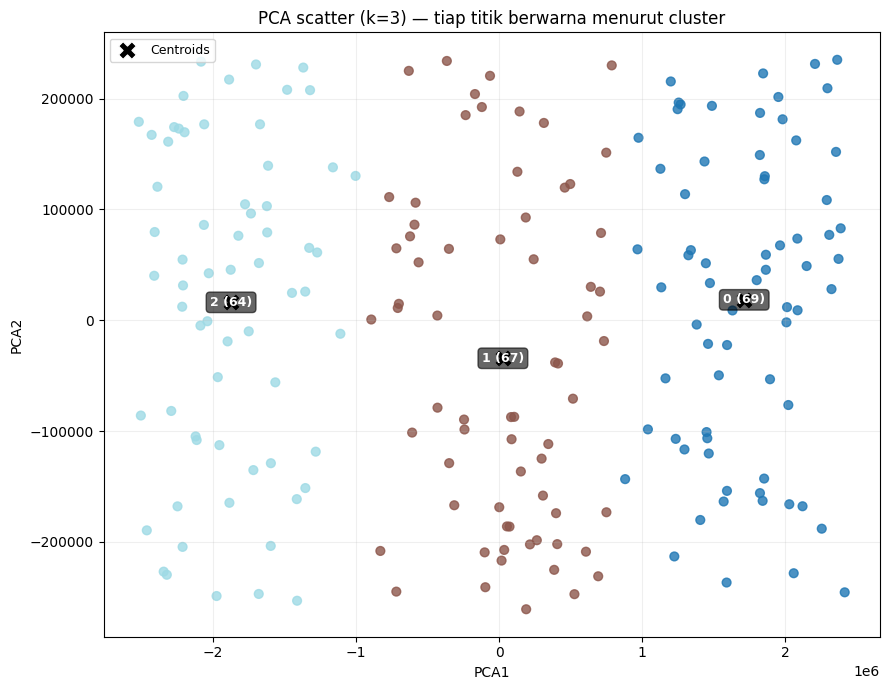

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,7))
# gunakan colormap yang jelas untuk banyak label
cmap = plt.get_cmap("tab20")
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap=cmap, s=40, alpha=0.8)

# centroid
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', marker='X', s=160, edgecolor='w', linewidth=0.8, label='Centroids')

# anotasi ukuran cluster di dekat centroid
for i, (cx, cy) in enumerate(centroids_pca):
    size = counts[i]
    plt.text(cx, cy, f"{unique_labels[i]} ({size})", fontsize=9, fontweight='bold',
             ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.3'))

plt.title(f"PCA scatter (k={result['chosen_k']}) — tiap titik berwarna menurut cluster")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid(alpha=0.2)
plt.legend(loc='best', fontsize=9)
plt.tight_layout()



Text(0.5, 1.02, 'Pairplot fitur (k=3)')

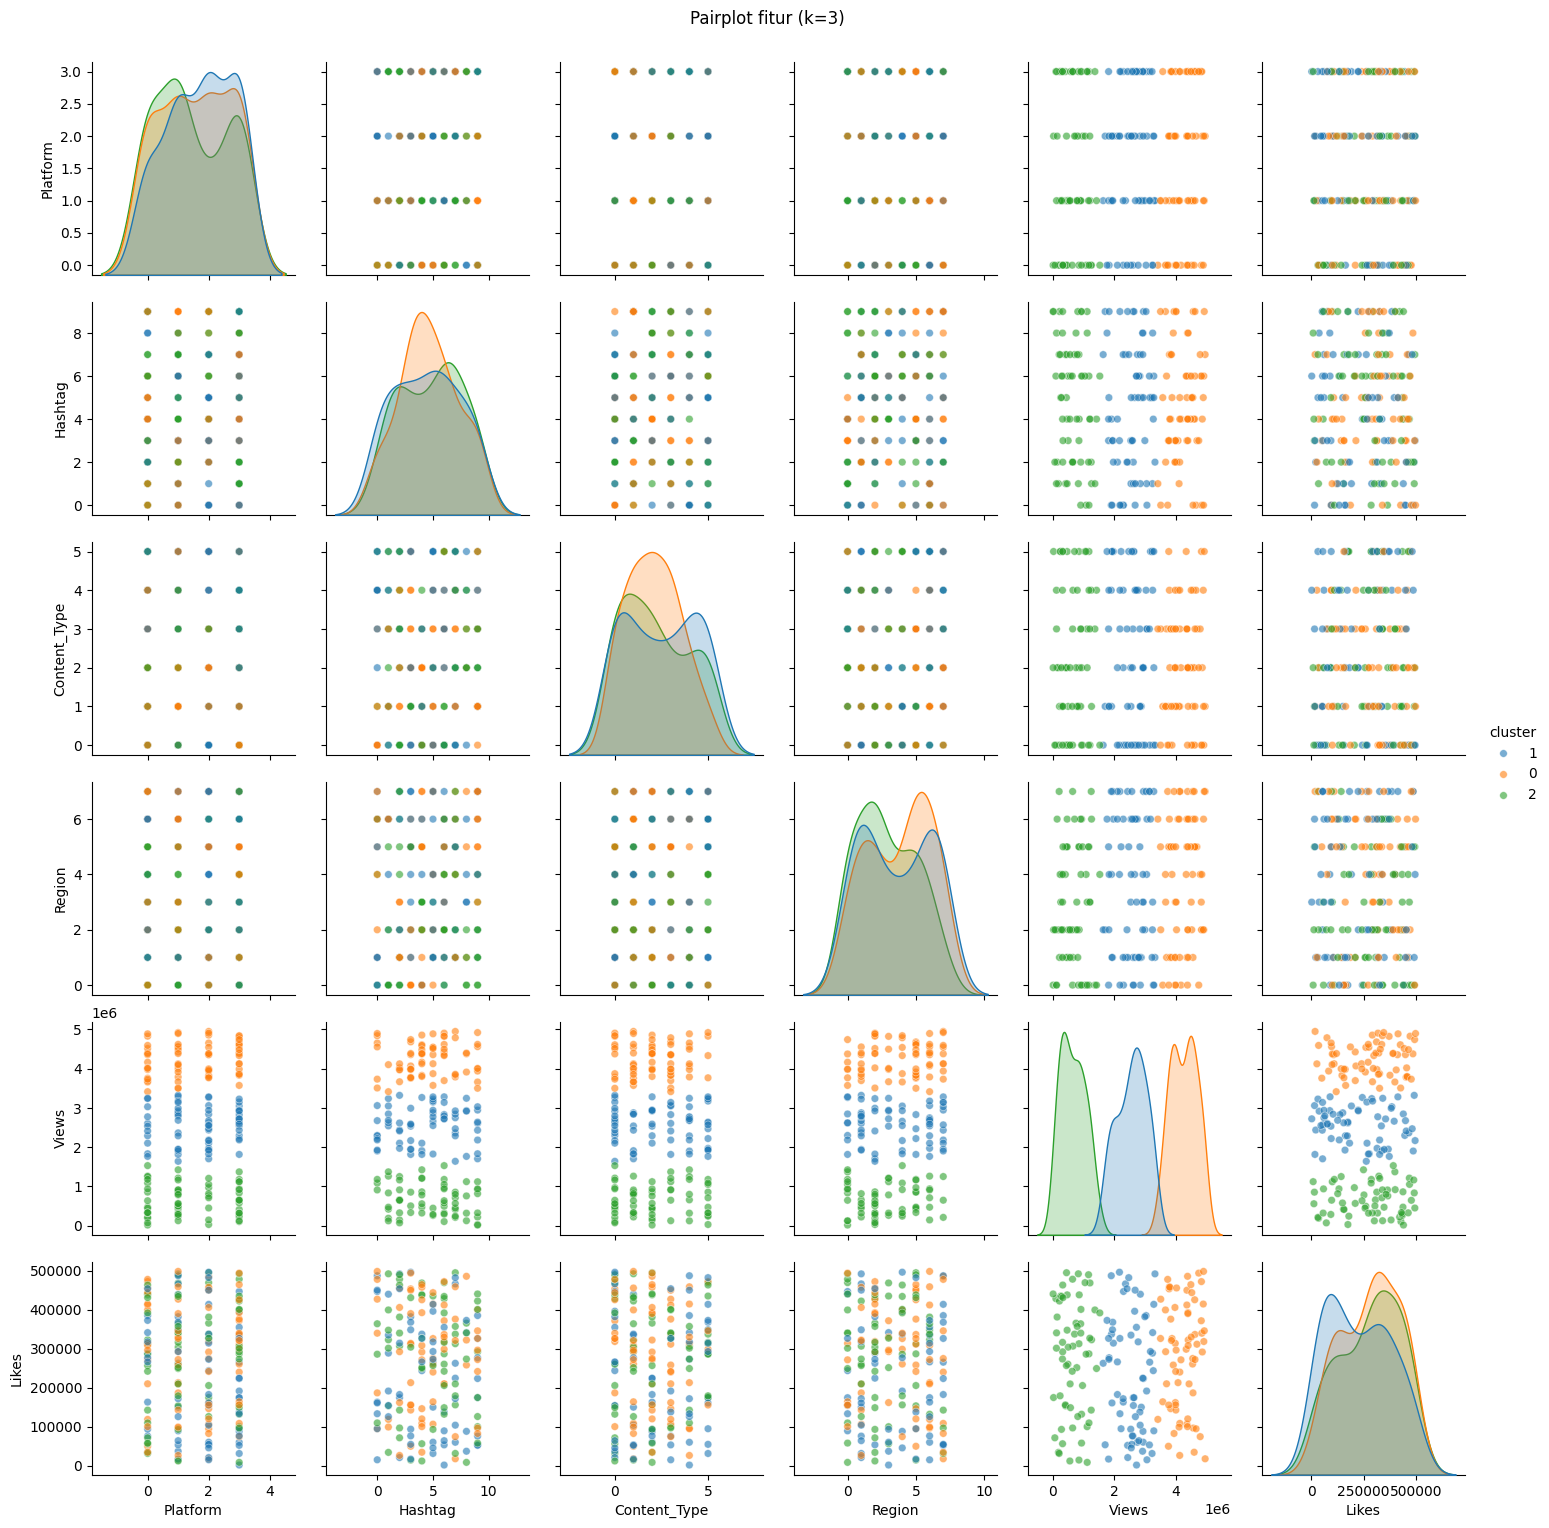

In [26]:
# Pairplot untuk subset kolom (pilih 4–6 fitur paling representatif)
cols_for_pair = feature_cols[:6] if len(feature_cols) >= 6 else feature_cols
df_plot = result_df.copy()
# Pastikan kolom yang dipilih ada
cols_for_pair = [c for c in cols_for_pair if c in df_plot.columns]
df_plot['cluster'] = df_plot['cluster'].astype(str)  # untuk hue
import seaborn as sns
sns.pairplot(df_plot[cols_for_pair + ['cluster']], hue='cluster', diag_kind='kde', corner=False, plot_kws={'alpha':0.6, 's':30})
plt.suptitle(f"Pairplot fitur (k={result['chosen_k']})", y=1.02)

